# KMeans
#### K-means is unsupervised machine learning algorithm for clustering data, it can be used for prediction by assigning new data points to the nearest cluster based on the trained model's cluster centers.
#### K-means is an unsupervised algorithm, meaning it doesn't rely on labeled data for training. It identifies patterns and groups data points into clusters based on similarity. 

In [1]:
# To turn off warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # To save & load the model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # For check Model Accuracy

In [3]:
# Load the dataset
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape

(200, 5)

In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [7]:
# Selecting features for clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [8]:
# Hyperparameter Tuning: Find the best k and best random_state using Silhouette Score
best_k = 2
best_random_state = 0
best_score = -1
best_model = None

wcss = []
silhouette_scores = []

for k in range(2, 11):  # Testing k from 2 to 10
    for random_state in range(0, 43):  # Testing random_state from 0 to 42
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=random_state)
        cluster_labels = kmeans.fit_predict(X)

        # Calculate WCSS (Elbow Method)
        if random_state == 0:
            wcss.append(kmeans.inertia_)  # Only store WCSS once per k

        # Calculate Silhouette Score
        score = silhouette_score(X, cluster_labels)

        # Save the best model based on the highest silhouette score
        if score > best_score:
            best_score = score
            best_k = k
            best_random_state = random_state
            best_model = kmeans

        # Store silhouette scores for visualization
        if random_state == 0:
            silhouette_scores.append(score)


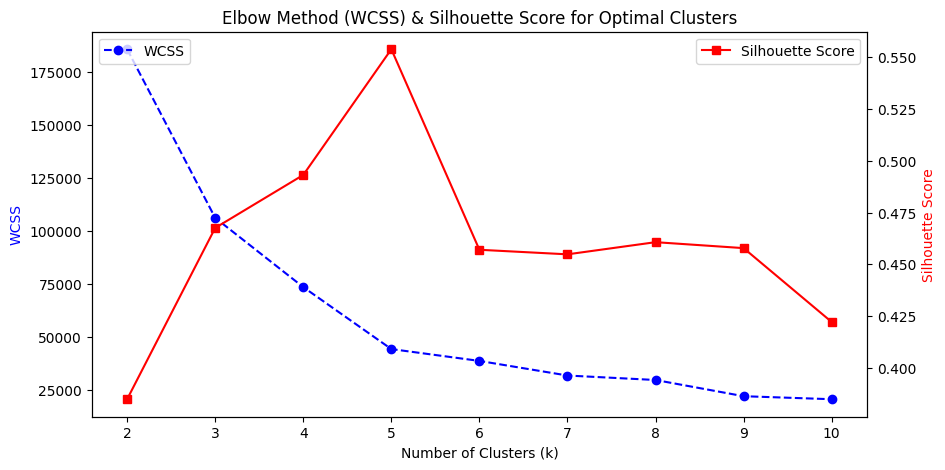

In [9]:
# Plot the Elbow Method and Silhouette Score
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()
ax1.plot(range(2, 11), wcss, marker='o', linestyle='--', label="WCSS", color='b')
ax2.plot(range(2, 11), silhouette_scores, marker='s', linestyle='-', label="Silhouette Score", color='r')

ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("WCSS", color='b')
ax2.set_ylabel("Silhouette Score", color='r')

ax1.set_title("Elbow Method (WCSS) & Silhouette Score for Optimal Clusters")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [10]:
# Train the best K-Means model
df["Cluster"] = best_model.fit_predict(X)

In [11]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,3
1,2,Male,21,15,81,4
2,3,Female,20,16,6,3
3,4,Female,23,16,77,4
4,5,Female,31,17,40,3


In [12]:
# Save the best K-Means model
joblib.dump(best_model, "kmeans_model.pkl")
print(f"Best K-Means model saved as best_kmeans_model.pkl with k={best_k} and Silhouette Score: {best_score:.4f}")

Best K-Means model saved as best_kmeans_model.pkl with k=5 and Silhouette Score: 0.5539


In [13]:
# Save clustered data
df.to_csv("Mall_Customers_with_Best_Clusters.csv", index=False)

In [14]:
# ====== Load Model and Make Predictions ======
# Load the trained best model
loaded_kmeans = joblib.load("kmeans_model.pkl")

# Predicting clusters for the existing customers
df["Predicted Cluster"] = loaded_kmeans.predict(X)

In [15]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Predicted Cluster
0,1,Male,19,15,39,3,3
1,2,Male,21,15,81,4,4
2,3,Female,20,16,6,3,3
3,4,Female,23,16,77,4,4
4,5,Female,31,17,40,3,3


In [16]:
df.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Predicted Cluster
195,196,Female,35,120,79,1,1
196,197,Female,45,126,28,2,2
197,198,Male,32,126,74,1,1
198,199,Male,32,137,18,2,2
199,200,Male,30,137,83,1,1


In [17]:
# Save predictions
df.to_csv("Mall_Customers_Predictions.csv", index=False)
print("Predictions saved in Mall_Customers_Predictions.csv")

Predictions saved in Mall_Customers_Predictions.csv


In [18]:
print(f"The model created {best_k} clusters.")

The model created 5 clusters.


In [19]:
df["Cluster"].value_counts()

Cluster
0    81
1    39
2    35
3    23
4    22
Name: count, dtype: int64

In [20]:
# Print Summary Statistics for Each Cluster
cluster_summary = df.groupby("Cluster").agg({
    "Annual Income (k$)": ["mean", "min", "max"],
    "Spending Score (1-100)": ["mean", "min", "max"],
    "CustomerID": "count"
})

print(cluster_summary)

        Annual Income (k$)          Spending Score (1-100)         CustomerID
                      mean min  max                   mean min max      count
Cluster                                                                      
0                55.296296  39   76              49.518519  34  61         81
1                86.538462  69  137              82.128205  63  97         39
2                88.200000  70  137              17.114286   1  39         35
3                26.304348  15   39              20.913043   3  40         23
4                25.727273  15   39              79.363636  61  99         22


## Cluster Representation

In [21]:
# Automatically find thresholds using quartiles
low_income_threshold = df["Annual Income (k$)"].quantile(0.33)  # 1st third (~40K)
high_income_threshold = df["Annual Income (k$)"].quantile(0.66) # 2nd third (~70K)

low_spending_threshold = df["Spending Score (1-100)"].quantile(0.33)  # 1st third (~40)
high_spending_threshold = df["Spending Score (1-100)"].quantile(0.66) # 2nd third (~60)

# Function to classify clusters based on calculated thresholds
def describe_cluster(row):
    income = row["Annual Income (k$)"]
    spending = row["Spending Score (1-100)"]

    if income < low_income_threshold and spending < low_spending_threshold:
        return "Low Income, Low Spender (Frugal)"
    elif income < low_income_threshold and spending > high_spending_threshold:
        return "Low Income, High Spender (Bargain Hunter)"
    elif income > high_income_threshold and spending < low_spending_threshold:
        return "High Income, Low Spender (Careful Saver)"
    elif income > high_income_threshold and spending > high_spending_threshold:
        return "High Income, High Spender (Luxury Shopper)"
    else:
        return "Medium Income, Medium Spender (Average Customer)"

# Apply function to cluster information
cluster_info = df.groupby("Cluster").agg({
    "Annual Income (k$)": "mean",
    "Spending Score (1-100)": "mean",
    "CustomerID": "count"
}).rename(columns={"CustomerID": "Customer Count"})

cluster_info["Cluster Description"] = cluster_info.apply(describe_cluster, axis=1)

# Print the final cluster descriptions
cluster_info

,Annual Income (k$),Spending Score (1-100),Customer Count,Cluster Description
Cluster,,,,
0,55.296296,49.518519,81,"Medium Income, Medium Spender (Average Customer)"
1,86.538462,82.128205,39,"High Income, High Spender (Luxury Shopper)"
2,88.200000,17.114286,35,"High Income, Low Spender (Careful Saver)"
3,26.304348,20.913043,23,"Low Income, Low Spender (Frugal)"
4,25.727273,79.363636,22,"Low Income, High Spender (Bargain Hunter)"


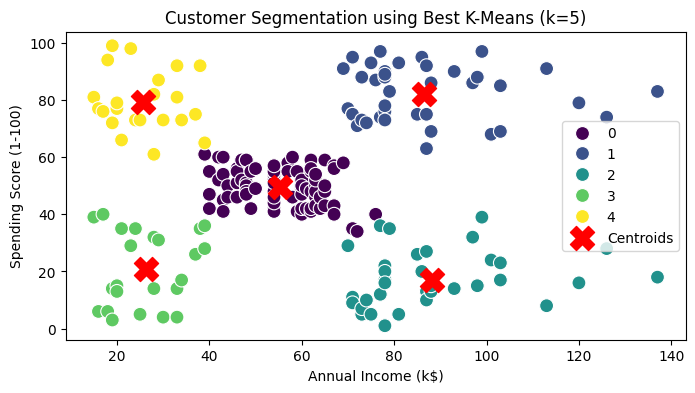

In [22]:
# Visualizing clusters
plt.figure(figsize=(8,4))
sns.scatterplot(x=df["Annual Income (k$)"], y=df["Spending Score (1-100)"],
                hue=df["Cluster"], palette="viridis", s=100)
plt.scatter(loaded_kmeans.cluster_centers_[:, 0], loaded_kmeans.cluster_centers_[:, 1], 
            s=300, c='red', marker='X', label="Centroids")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title(f"Customer Segmentation using Best K-Means (k={best_k})")
plt.legend()
plt.show()

In [23]:
# Print sample predictions and model performance
print(f"Best Model: k={best_k}, Silhouette Score={best_score:.4f}")
print(df[["CustomerID", "Annual Income (k$)", "Spending Score (1-100)", "Predicted Cluster"]].head())

Best Model: k=5, Silhouette Score=0.5539
   CustomerID  Annual Income (k$)  Spending Score (1-100)  Predicted Cluster
0           1                  15                      39                  3
1           2                  15                      81                  4
2           3                  16                       6                  3
3           4                  16                      77                  4
4           5                  17                      40                  3


In [24]:
# ====== Make Predictions for a New Customer ======
new_customer = np.array([[70, 80]])  # Example: 70K annual income, 80 spending score
predicted_cluster = loaded_kmeans.predict(new_customer)

print(f"New customer with Income 70K and Spending Score 80 belongs to Cluster {predicted_cluster[0]}")

New customer with Income 70K and Spending Score 80 belongs to Cluster 1


# Remarks
The **Silhouette Score** ranges between **-1 and 1**, where:  

- **+1** → Clusters are **well-separated** (ideal clustering).  
- **0** → Clusters are **overlapping** (not well-defined).  
- **-1** → Clusters are **incorrectly assigned** (bad clustering).  

### **What is a Good Silhouette Score?**  
- **Above 0.5** → **Strong structure** (Good clustering).  
- **Between 0.25 - 0.5** → **Decent clustering**, but could be improved.  
- **Below 0.25** → **Weak clustering**, meaning data points are not well-separated.  

### **Ideal Value for K-Means?**  
- A **Silhouette Score > 0.5** is **ideal**.  
- If the score is too low, consider **changing the number of clusters (k)** or using a **different clustering algorithm** like DBSCAN or Gaussian Mixture Models (GMM).  

